<a href="https://colab.research.google.com/github/kalebsampaco/DataEngineering_Platzi_Course/blob/master/Copia_de_MNIST_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoteBook tutorial de Deep Learning; Redes Fully Conected

## Alcance

El alcance de este notebook es el de mostrar la teoria detras de las arquitecturas de redes neuronales Fully Conected, así como el de mostrar paso a paso como resolver un problema de identificación de digitos sencillo usando Keras.

---

### Introducción

El deep learning es la disciplina de la inteligencía artificial que aprende automaticamente las caracterisitcas de un DataSet directamente de la data a distintos niveles de abstracción. Se dice que un algoritmo pertenece a esta categoria cuando hay más de una capa oculta entre la capa de entrada y de salida.

En terminos de eficiencia es similar al del Machine Learning tradicional, si se abarca la misma cantidad de datos que este ultimo usa. Sin embargo al enfrentarse a problemas con máyor nivel de abstracción y manejo de datos el deep learning es superior, por esta razón es usado para analisis de imagen, texto, video y audio.

![Dl-ML.png](https://preview.ibb.co/d3CEOH/1.png)

Cuando se habla de máyor nivel de abstracción es dificil indicar un valor en sí, pero una heuristica es que se maneja alrededor de datos de un millon o más.

![Dl-ML-2.png](https://preview.ibb.co/hgpNAx/2.png)

Imagenes tomadas de Deep Learning Tutorial for beginners | Kaggle

---

Este notebook trabaja con el dataset MNIST Digits de Kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
%cd "/content/gdrive/My Drive/MNIST"

/content/gdrive/My Drive/MNIST


Como en todo problema de ML, DL. El primer paso es entender la naturaleza del problema y su relación con la data. Para el caso del DataSet MNIST - Digit, consta de un archivo en csv, donde la primera columna guarda la información de tipo de digito es: un numero del 0 al 9, mientras que las otras 784 columnas guardan la información de cada pixel, para una imagen de 28x28 de un solo canal. La información del csv es de tipo int.

In [ ]:
train = pd.read_csv('./train/train.csv')
test = pd.read_csv('./test/test.csv')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

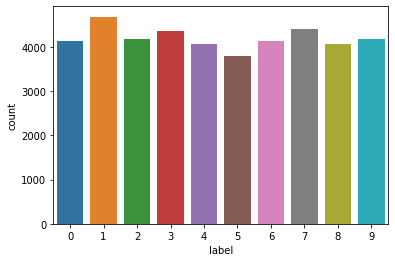

In [ ]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [ ]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### Preparando la data

Es una buena practica en DL, separar la data de entrada en dos sets uno de entrenamiento y otro de validación, esto con el proposito de evaluar la arquitectura de la red neuronal y hacer los ajustes nesesarios para evitar que esta se sobreajuste.

Para este caso se puede usar la función de SciKit Learn train_test_split, la data se puede separar, 90% entrenamiento, 10% validación o 80% entrenamiento, 20% validación. Para este caso se usara 80-20.

Por otra parte las redes nuronales trabajan mejor con datos normalizados, acotados en rangos pequeños. Los más comunes son de 0 a 1, -1 a 1 o -3 a 3. Para este caso se reducira de 0 a 1, diviendo por 255.

In [ ]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [ ]:
# Set the random seed
random_seed = 2

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

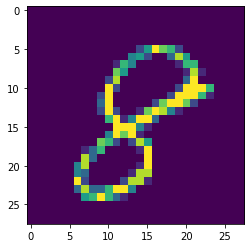

In [ ]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

### Entendiendo las redes neuronales

Antes de analizar la arquitectura para este DataSet, vamos a hacer un repaso general detras de la teoria de grafos.

#### Grafos

Los grafos son estrucutaras dinamicas con una relación no líneal que permiten representar relaciones binarias entre elementos de un conjunto, sin embargo esta explicación es un poco vaga. Para mí son una excelente herramienta en computación para representar graficamente expresiones matematicas.

Por ejemplo la expresión:

>$c=\sqrt{a²+b²}$

Se puede expresar con el siguiente grafo:

![Graph.jpg](https://image.ibb.co/hWn6Lx/d.jpg)

Las redes neuronales multiples se apoyan fuertemente en la regresión lineal multiple. Como ejemplo usando el dataset SIGNS de clase, el grafo para expresar la operación matematica de si una imagen es la representación de uno o no sería este:

![Graph%20signs%20one.jpg](https://preview.ibb.co/cxP63H/5.jpg)

Donde la capa de entrada está compuesta del valor numerico de cada pixel y cada uno tiene asignado un peso. Volviendo a nuestro ejercicio, recordemos que las 784 columnas de cada DataSet contienen la información de cada pixel, esto nos lleva a concluir dos cosas:

1. La capa de entrada es un tensor de una sola dimensión, usualmente un tensor largo donde se encuentra de forma secuencial la información a procesar, en el caso de las imagenes, la información de cada pixel.
2. Ya los datasets, están listos para ser procesados por una red neuronal.

#### La red neuronal

Las redes neuronales artificiales o redes fully connected emulan el funcionamiento de las redes neuronas humanas. La neurona tiene un grupo de señales de entrada y una sola salida.

![Perceptron.png](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.YPguig_eDkgWi5cgvWiUBgHaEB%26pid%3DApi&f=1)

A este grafo se le conoce como perceptron. Sin embargo así como una neurona no es un cerebro humano, un perceptron por si solo no es una red neuronal artificial.

#### Capas ocultas

Volviendo al ejemplo del dataset Signs, surge la duda ¿Qué estoy detectando con mi grafo original? la respuesta sería caracteristicas, sin embargo son caracteristicas básicas, los contornos de la imagen para ser exactos. Estas formas por si solas solo me dan una probabilidad del 50% de dicernir si la imagen es un uno o no, un resultado mediocre, es acá donde nos volvemos a apoyar en la naturaleza para mejorar nuestro resultado. 

Existe un concepto en el mundo natural llamado emergencia, cuando organismos simples se agrupan de forma organizada para asegurar su supervivencia, esto se puede observar en una colina de hormigas, una hormiga por si sola, es debil, una colina de hormigas puede realizar estructuras subterraneas complejas para garantizar su supervivencia. 

Así que si entre mi capa de entrada y salida inserto una capa adicional que me perimita detectar formas más complejas podria no solo detectar los contornos sino también formas convexas y caracterisitcas unicas como el dedo gordo de la mano.

![Capas%20ocultas.jpg](https://preview.ibb.co/mpD4Qx/10.jpg)

A esta capa se le conoce como capa oculta, se dice que es oculta porque sus valores de entrada no son los inputs obtenidos del dataset, son ocultos tanto para el usuario como para el programador.

Ahora, si recordamos el principio detras de las redes neuronales su esqueleto es el de una regresión lineal multiple, así mismo no serviria incluir una capa oculta entre la entrada y la salida simplemente, estas colapsarian en un perceptron gigante, que no nos aportaria nada. Se hace nesesario incluir una función de activación entre la capa oculta y la capa de salida para que distorsione la naturaleza lineal entre las capas y nos permita obtener la extracción de caracteristicas que nesecitamos.

Este seria el grafo de una red con dos perceptrones:

![Multi-perceptron.jpg](https://preview.ibb.co/dajVyH/9.jpg)

Ahora recordemos, que cada input o neurona tiene asociado un peso, no sería util y en realidad seria bastante tedioso asignar manualmente el peso de cada uno. Es acá donde entra el concepto de inteligencia artificial, es más util que sea el computador el que decida que peso debe tener cada neurona. 

#### Backpropagation

Esto es posible con el algoritmo de BackPropagation. Este algoritmo es la base del exito de las redes neuronales. Este evalua de acuerdo al resultado final de la red capa por capa cual es el peso adecuado que debe tener cada neurona. Este proceso es iterativo a mayores iteraciones, mejores resultados. Un recorrido por el dataset se conoce como epoca(epoch).

Bajo este escenario se puede categorizar a las redes neuronales como algoritmos de aprendizaje supervizados.

Es importante recordar acá los conceptos de sobreajuste(overfitting) y subajuste(underfitting), existen varias formas de monitorear el desempeño de una red en relación a estos dos conceptos, la mejor forma es visual.

Aprendizaje con sobreajuste:

![Sobreajuste.png](https://developers.google.com/machine-learning/crash-course/images/RegularizationTwoLossFunctions.svg)

Aprendizaje con subajuste:

![Subajuste.png](https://c.mql5.com/2/30/SRBM_9_upperLayer_9_RP.png)

Aprendizaje optimo:

![Buen%20ajuste.png](https://c.mql5.com/2/30/SRBM_b_RP.png)

Es importante definir las epocas suficientes para que un modelo se entrene, un valor comun para empezar es 100 epochs.

En caso de que un modelo presente subajuste se recomienda:

* Aumentar la cantidad de capas.
* Agregar más neuronas por capa.
* Aumentar el numero de epocas
* Eligir un metodo de optimización más complejo

En casode que un modelo presente sobreajuste se recomienda:

* Entrenar con más datos
* Utilizar técnicas de regularización.

En base a esta definición se nesecita entonces definir una función matematica que evalue el error de de la red y un optimizador que minimice el error de esta. O dicho de otra forma que determine los parametros en los que la función de error sea mínima.

#### Optimizadores y funciones de perdida o coste

El optimizador más comun es SGD (Stochastic Gradient Descent).

![SGD.jpg](https://image.ibb.co/dAaYJH/7.jpg)

No obstante existen varios optimizadores, siendo el favorito de la comunidad Adam, que combina los principios matematicos de Momentum y AdaBoost.

En estos links de youtube hay más información sobre cada uno:

Adaboost
https://www.youtube.com/watch?v=LsK-xG1cLYA

Momentum
https://www.youtube.com/watch?v=6iwvtzXZ4Mo

La información hasta al momento nos lleva a concluir dos conceptos adicionales:

1. Se debe definir la función matematica adecuada para determinar el error de la red neuronal
2. Se debe definir las funciones de activación de las capas ocultas y la capa final para evitar que la red neuronal colapse en un perceptron gigante.

La función que determina el error de la red se conoce como función de perdidad. Esta y las funciones de activación están muy relacionadas a la naturaleza del problema, según la experiencia general de la comunidad los problemas más comunes y sus funciones son:

* Problemas de regressión simple: Para este caso la ultima capa tiene una neurona, no se hace nesesario definir una función de activación final, la función de activación intermedia es ReLU y su función de perdida es el error cuadratico promedio.
* Problemas de clasificación binaria: La ultima capa tiene una neurona, la función de activación final es sigmoide o log_sigmoide, la función de activación intermedia es ReLU o Tanh y su función de perdida es entropia cruzada binaria. Se puede usar entropia cruzada pero cambiando la ultima capa a dos valores y sustrayendo la función de activación sigmoide.
* Problemas de clasificación multiclase una sola label(etiqueta): El numero de neuronas en la capa de salida es igual la numero de clases a clasificar, la función de activación final es softmax o log-softmax, la función de activación intermedia es ReLU o Tanh y su función de perdida final es NLL(Negative log-likelihood) o entropia cruzada.
* Problemas de clasificación multiclase y multilabel(varias etiquetas): El numero de neuronas en la capa de salida es igual la numero de clases a clasificar, la función de activación final es sigmoide o log-sigmoide, la función de activación intermedia es ReLU o Tanh y su función de perdida final es entropia cruzada bianaria.

#### Hiperparametros

En este punto podemos inferir que existen parametros nesesarios para la correcta operación de una red neuronal, pero que no existe una forma presisa de definirlos, su selección se determina más por prueba y error, estos son en orden de importancía:

* Learning rate
* Optimizador
* Mini-batch-size
* Cantidad de neuronas en capas ocultas
* Cantidad de capas ocultas

Como técnicas de definición de hiperparametros están:

* Forma manual
* Forma aleatoria
* Metodos Bayesianos

La más usada es la forma aleatoria y por hiperparametro, los metodos manuales son engorrosos y los metodos bayesianos, son computacionalmente costosos; aunque potentes.

-------------

### Redes convolucionales vs redes multi-capa(fully conected)

En el tutorial anterior vimos como las redes multicapa son poderosas por si solas,logrando una presición del 90% sin mucho esfuerzo. Resulta que en el ambito profesional donde se maneja información más compleja, por si solas no son tan utiles, la raiz principal de este problema es que el input de estos algoritmos es un vector plano que contenga toda la información pertinente. En el problema anterior fue sencillo solucionar el problema dado que el dataset de MNIST digit son vecotores planos con toda la información pertinente de la imagen. En el mundo real el input va a ser una imagen a color o en el mejor de los casos una imagen a blanco y negro. Esto se traduce en el mejor de los casos un tensor de 32x32x1 y en el peor un tensor de 32x32x3, esto asumiendo que la imagen es pequeña, usualmente tampoco es así. Ambos casos tienen como input algo muy diferentes a un vector plano.

La solución más sencilla seria aplanar el tensor, sin embargo al hacer esto se pierde información importante para el analisis, los contrastes de luz y sombras que estan embebidos en los arreglos de pixeles, es acá donde entran las redes convolucionales.

A través de la operación matematica de convolución se le aplican filtros a la imagen que permiten conservar estos contrastes en un valor numerico que conserva la información y si se puede aplanar.

#### Entendiendo las redes convolucionales

Las redes convolucionales usan tres tipos de capas para operar:

* Capas Convolucionales
* Capas de Pooling
* Capas profundas (fully conected)

Vamos a revisar cada una en detalle:

![CNN_car.png](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b1070e4_screen-shot-2018-05-31-at-2.59.36-pm/screen-shot-2018-05-31-at-2.59.36-pm.png)

##### La capa convolucional

Para entender el concepto de capa convolucional primero se hace nesesario entender el concepto de filtros, En especifico los llamados high-pass filters.

Para detectar cambios de intensidad dentro de una imagen se hace nesesario crear filtros especificos que buscan grupos de pixeles y reaccionan a patrones alternos de luz y sombra en la imagen. Estos filtros producen una salida que muestra los bordes de objetos y de diferentes texturas. Aća la diferencia con las redes fully connected que a medida que amuentan sus capas aumentan también su abastracción de bordes, las convoluciones permiten incluir las texturas a la ecuación. 

Estos filtros se construyen de acuerdo a un tamaño, conocido como tamaño de ventana. que no es nada más que una matriz como esta:

![giphy.gif](https://media.giphy.com/media/jrzu0JxxZydz0valeu/giphy.gif)

Estas ventanas tienen un tamaño usualmente de 3x3 que le ayuda a la red convolucional a identificar patrones en una imagen. Estos filtros a su vez pueden ser modificados para obtener diferentes filtros en la salida, es comun que en una red convolucional haya una gran cantidad de filtros, la agrupación de estos se conoce como kernel.

![kernels_CNN.png](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b10723a_screen-shot-2018-05-31-at-3.06.07-pm/screen-shot-2018-05-31-at-3.06.07-pm.png)

En la figura mostrada 4 diferentes filtros producen cuatro imagenes filtradas, cuando apilamos estas imagenes formamos una red convolucional de profundidad igual a cuatro.

![CNN%20depth.png](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5b10729b_screen-shot-2018-05-31-at-3.07.03-pm/screen-shot-2018-05-31-at-3.07.03-pm.png)

La profundidad de cada capa arreglada de manera consecutiva produce una red capaz de identificar patrones y caracteristicas increiblemente complejas, de la misma forma en la que nuestro cerebro interpreta lo que vemos.

Hay otros dos conceptos secundarios al definir una convolución, que sin embargo bien usados pueden mejorar o empeorar una red.

El primero es stride, el stride es el paso del filtro por la imagen, como valor default se usa 1, esto se traduce en un filtro que avanza pixel por pixel. Si se cambiase a dos el kernel avanzaria cada dos pixeles.

El segundo concepto es el de padding, si has trabajado en diseño frontend web tal vez te suene familiar la idea. En redes convolucionales es el siguiente: los filtros usualmente son matrices cuadradas, sin embargo al operar en una matriz no cuadrada se presentan problemas en la operación de convolución, para estos casos que son la gran mayoria, se aplica un relleno alrededor de la imagen, este relleno es el padding, el valor default es 1,aunque también se puede trabajar con 0.

##### Max Pooling

Bien ya tenemos una red capaz de detectar los patrones y caracteristicas, que nuestra red neuronal multiple por si sola no hubise podido. Sin embargo si procesamos esta información como esta nuestro algoritmo pude demorarse eternidades en procesarse o no tener memoria para lograrlo. Es acá dondeentran las capas de pooling o Max Pool.

La operación de Pooling es usada en las redes convolucionales para hacer la detección de ciertas caracteristicas que podrián considerarse constantes en escala y cambios de orientación. Otra manera de entender este concepto es ver a la operación como una manera de generalizar información compleja sobre bajos niveles.

Similar a la convolución, la operación consiste de una ventana de tamaño fijo que recorre la imagen y dentro de la ventana cálcula un valor de acuerdo a la metrica que está establecida para esta operación. Como resultado obtiene un nuevo tensor.

Cuando la metrica consiste en encontrar el máximo valor de la ventana, la operación se conoce como Max Pooling. También existe Average Pooling que determina el valor promedio. Como alternativa a la operación de pooling existe un concepto llamado redes de capsula, en la siguiente imagen se muestra la operación de max pool.

![giphy-pool.gif](https://media.giphy.com/media/U7PsR7cv9oIcB6eEAd/giphy.gif)

Cuando combinamos las capas de Pooling con las capas convolucionales reducimos la dimensión de la información, solucionando el problema de capacidad computacional y garantizando que la información procesada sea la de mayor importancia minimzando la perdida de la misma.

Asi nuestro modelo se transforma en algo así:

![Cn%20y%20Maxpool.png](https://i.ibb.co/V06mcY0/Intro-to-Deep-Learning-with-Py-Torch-Udacity-classroom-udacity-com.png)

##### Capas profundas

Las capas profundas son las que ya conocemos y es la ultima pieza de una red Convolucional. Así la arquitectura de nuestra red sería algo así:

![CNN.png](https://cs231n.github.io/assets/cnn/convnet.jpeg)

Una vez ya entendemos como funciona una red convolucional es hora de definir su arquitectura.

Para la solucióón de este problema se define una arquitectura de dos capas convolucionales con maxpool, una red neuronal con dos capas ocultas y como metodo de regularización Dropout. Como es una problema de clasificación multiclase, la función de activación para la capa final es softmax y la funcióón de activación para las capas intermedias es ReLU 


In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Una vez definida la arquitectura el siguiente paso es definir la metrica de evaluación, la función de perdida y el algoritmo de optimización.

La función de perdida es la encargada de medir que tan pobre es el desempeño de nuestra red a la hora de predecir el contenido de una imagen con una etiqueta conocida. Para este caso especifico escogí una forma de clasificación categorica llamada "categorical_crossentropy".

El siguiente paso es definir el algoritmo de optimizacióón, este es el paso más importante. Ya que este tiene la tarea de mejorar en cada iteración parametros como: valores de los filtros, pesos de neuronas, cesgo de neuronas, etc. Todo esto buscando minimizar la funcióón de perdida.

Para este caso escogí un sabor particular de Adam llamado RMSprop con sus valores por default. Otra opcióón puede ser SGD, pero es máás demorado.

Por ultimo se define la metrica de evalucióm, para este caso por accuracy.

----
Para optimizar los hiperparametros, en este caso usare un metodo de keras llamado ReduceLROnPlateau, esta poderosa herramienta me permite decrementar el leraning rate durante el entrenamiento con la condición de si no se presentan mejoras en el accuracy despues de dos epocas. Este metodo combina la busqueda aleatoria de hiperparametros como es el RandomGridSearch con metodos de montecarlo. De esta manera se logra aprovechar la velocidad de computo de la busqueda aletoria garantizando resultados que no caigan en minimos locales, en el siguiente enlace esta la información de este metodo para elque le interese:

https://keras.io/api/callbacks/reduce_lr_on_plateau/









In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 30 
batch_size = 86

### Data Augmentation

Una técnica de regularización exclusiva para imagenes es el data augmentation, una buena heuristica para detrminar su uso o no, es analizar el dataset y detrminar si la información de entrenamiento es mayor al 90%. La mejor forma de entender sus técncias de uso es entender como se maneja una imagen, más información aqui:

https://scikit-image.org/docs/dev/auto_examples/index.html

Usar estas técnicas requiere más capacidad de computo, pero pueden elevar un accuracy de 0.97 a 0.99

para este caso las operaciónes que escogí fueron:

* Aleatoriamente rotar algunas imagenes de entrenamiento 10 grados.
* Aleatoriamente hacer zoom en 10% a algunas imagenes de entrenamiento
* Aleatoriamente cambiar el ancho de imagenes en un 10%
* Aleatoriamente cambiar el alto de imagenes en un 10%

No obstante el limite de operaciones lo define la imaginación.

In [ ]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

### Entrenando el modelo

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 244s - loss: 0.4232 - accuracy: 0.8637 - val_loss: 0.0825 - val_accuracy: 0.9740
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 241s - loss: 0.1292 - accuracy: 0.9615 - val_loss: 0.0423 - val_accuracy: 0.9871
Epoch 3/30
 - 243s - loss: 0.0972 - accuracy: 0.9711 - val_loss: 0.0286 - val_accuracy: 0.9921
Epoch 4/30
 - 247s - loss: 0.0796 - accuracy: 0.9766 - val_loss: 0.0296 - val_accuracy: 0.9912
Epoch 5/30
 - 244s - loss: 0.0737 - accuracy: 0.9789 - val_loss: 0.0278 - val_accuracy: 0.9912
Epoch 6/30
 - 247s - loss: 0.0647 - accuracy: 0.9808 - val_loss: 0.0444 - val_accuracy: 0.9879
Epoch 7/30
 - 242s - loss: 0.0628 - accuracy: 0.9821 - val_loss: 0.0227 - val_accuracy: 0.9933
Epoch 8/30
 - 246s - loss: 0.0624 - accuracy: 0.9826 - val_loss: 0.0251 - val_accuracy: 0.9926
Epoch 9/30
 - 249s - loss: 0.0583 - accuracy: 0.9834 - val_loss: 0.0217 - val_accuracy: 0.9924
Epoch 10/30
 - 243s - loss: 0.0594 - accuracy: 0.9835 - val_loss: 0.0310 - val_accuracy: 0.9912
Epoch 11/30
 - 246s - loss: 0.0598 - accuracy: 0.9835 - val_loss: 0.0203 - val_accuracy: 0.9938
Epoch 12/30
 - 245s - loss: 0.0603 - accuracy: 0.9831 - val

### Evaluando el modelo, matriz de confución

La matriz de confución es una herramienta excelente para evaluar la presición y sensibilidad de un modelo. El siguiente codigo imprime la matriz.

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

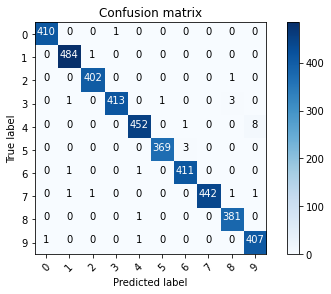

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se puede observar que la red opera con buenos resultados, solo algunos errores en un set de 4200 imagenes.

Es posible usar otro bloque de codigo para revisar estos errores.

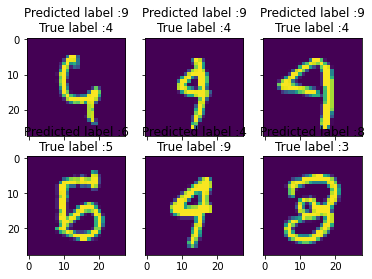

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Se puede observar que son errores que hasta un humano cometeria, bajo este escenario se puede concluir que el modelo ha sido exitoso y ya se puede guardar sus resultados o bien el mismo para ser consumido por un App.

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")